In [1]:
import pandas as pd
import matplotlib.pyplot as plt
#import pyreadr
import numpy as np
import mplcursors

Import data

Start by running locally, we'll work our way up to reading from the internet

Overarching design for this toolbox is as follows.

First, we design a state class to house necessary information.  Now, the issue is each state has different naming conventions on how it stores its data, so we then generate a set of easy to understand names to use.  After we have the easy-to-use names, we build a map that maps the easy-to-use names to the specific term the state uses.  From there, we can now write generalizable functions in terms of the easy-to-use names, and it works for every state as long as the map is set up.

## General Terms

First, we design a universal set of names to refer to information that is needed for our analysis.  These general terms are:
1.	Year: the year the sentencing occurred.
2.	County: the county of where the sentencing occurred.
3.	District: the district the sentencing occurred.
4.	Race: the race of the individual sentenced
5.	Departure: what kind of departure, if any occurred in the sentencing.  Levels could be Above Departure (sentencing greater than guideline), Within Range,  Below Range (sentence is below the guideline), or Indeterminable.
6.	Judge: the name of the Judge that sentenced the individual
7.	Sex: the sex of the individual sentenced

The idea here is we have these general, understandable terms.  State datasets vary from state to state, so we build a map to relate the general, usable term to the specific term the state uses.  This is useful for two reasons

1.	This map makes writing functions universal because of the maps.  Since we know that we can use, for example, Year to access the year data, we can always use Year rather than have to write a new function for every state.
2.	It makes reading and writing code easy to understand.  Rather than knowing durdep means duration in the Minnesota dataset, all you have to know is the general terms and the maps do all the hard work of relating the easy term to the hard one.


# Class State
Designed to be a container to hold all the necessary information for a specific state.  This class has 3 attributes
* Name:  Stores the name of the state
* Data: stores the dataframe for that state’s data
* Paths: this is a dictionary that maps the easy to use names to the specific names the state’s dataset uses.
* Paths always has 1 of the two formats:
    1. paths\[general term\] = \[specific_state_term\]
    2. paths\[general term\] = \[specific_state_term, dictionary describing the levels of that term\]
    
State objects are the core of this toolbox.  Every function is written with a state object being passed in.  The function takes the state object, then uses the genral terms, paths, and the states data to produce the desiered output.

In [42]:
class State:
    def __init__(self, inp_name, inp_data_url, inp_paths, 
                 order_of_outputs = ['Above Departure', 'Within Range', 'Below Range', 
                                        'Missing, Indeterminable, or Inapplicable']):
        self.name = inp_name
        
        
        url=inp_data_url
        url='https://drive.google.com/uc?id=' + url.split('/')[-2]
        self.data = pd.read_csv(url, low_memory = False)  # pandas dataframe object
        
        self.paths = inp_paths  # dictionary object.  
        # Always follows the format useful_id --> (name_in_data, dict(levels)).
        # Levels doesn't always exist, but is needed for variables like departure
        #path pairs are always (name_in_data, dict(levels)) or (name_in_data, None)
        
        self.order_of_outputs = order_of_outputs
        #this is how you want to arrange your output on graphs
        #is basically the order of the levels in paths[departure][1]
        
        self.average_percents= []  #list, for all years, state averages for all people
        self.yearly_average_percents = {}  # dictionary, state averages for all people for each year
                                             # format of: year (int) --> [averages_list]
        
        self.years = np.sort(self.data[self.paths['year'][0]].unique())  # generate a sorted list of years for data

        
        
        ###  get average_percents
        counts = self.data.groupby(self.paths['departure'][0]).count()
        counts = counts.rename(self.paths['departure'][1])
        counts = counts.iloc[:,0]

        for item in self.order_of_outputs:
            self.average_percents.append(round((100 * counts.loc[item]  /  self.data.shape[0]),2))
        
        ### get yearly_average_percents
        for year in self.years:
            subset_dat = self.data[ self.data[self.paths['year'][0] ] == year]
            counts = subset_dat.groupby(self.paths['departure'][0]).count()
            counts = counts.rename(self.paths['departure'][1])
            counts = counts.iloc[:,0]
            
            percentages = []
            for item in self.order_of_outputs:
                percentages.append(round((100 * counts.loc[item]  /  subset_dat.shape[0]),2))
            self.yearly_average_percents[year] = percentages
        

This code is setting up the minnesota state

In [44]:
states = {}  # dictionary to hold all states.  maps dict['state name'] --> state object for that state
paths = {}  # temporary paths dicitonary that will be passed into the creation of minnesota state object
paths['county'] = ['countyname', None]
paths['year'] = ['sentyear', None]
paths['district'] = ['district', None]
paths['race'] = ['race', {0:'NA', 
                         'white':'White', 
                         'black':'Black', 
                         'amind':'American Indian',
                         'hispanic': 'Hispanic',
                         'asian': 'Asian',
                         'other': ' Other',
                         None: 'Unknown'}]
paths['departure'] = ['durdep', {0:'Within Range', 
                                 1:'Above Departure', 
                                 2:'Below Range', 
                                 3:'Missing, Indeterminable, or Inapplicable'}]
paths['judge'] = ['judge', None]
paths['sex'] = ['sex', {1: 'Male', 
                        2: 'Female'}]
paths['age'] = ['Agecat', {1: 'Under 18', 
                           2: '18-21', 
                           3: '22-25', 
                           4: '26-30',
                           5: '31-40',
                           6: '41-50',
                           7: '51+'}]

#now that we have the information, we create the minnesota state object and add it to the states dictionary
states['minnesota'] = State('minnesota', 
                            'https://drive.google.com/file/d/1uz_-qgvObAPcB444fEhb_QizWSiKe-eg/view?usp=sharing', 
                            paths)

# Plotting Functions

## horizontal bar graph
This function is used to plot a horizontal bar graph to view results.

Parameters:
* departure_labels: the labels on our departure variable.  This is the x labels
* departure_porportions: the porportions for each label.  This is the y label.
* subgroup: the subgroup that this bar graph corrosponds to (used in the title).  Only used when looking at more than one level.
* s: for formatting, adds an s to the end of the title string

In [4]:
def plot_departures_bar(departure_labels, departure_porportions, subgroup, s = True):
    subgroup_str = ''
    for item in subgroup:
        subgroup_str += str(item) + ' '
    if s:  
        subgroup_str = subgroup_str[:-1]
        subgroup_str+='s'
        
    fig, ax = plt.subplots(figsize = (10,7))
    colors = ['lightcoral', 'lightgrey', 'cornflowerblue', 'turquoise']
    
    barh = ax.barh(departure_labels, departure_porportions, color=colors)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Percentage')
    
    ax.bar_label(barh, fmt='%.2f%%')
    ax.set_xlim(right=100)
    
    ttl = 'Porportional sentences for '+ subgroup_str
    ax.set_title(ttl)

## Pie chart

This function is used to plot a pie chart to view results.  This is just like the hoizontal bar graph, but a pie chart.

Parameters:
* departure_labels: the labels on our departure variable.  This is the x labels
* departure_porportions: the porportions for each label.  This is the y label.
* subgroup: the subgroup that this bar graph corrosponds to (used in the title).  Only used when looking at more than one level.
* s: for formatting, adds an s to the end of the title string

In [5]:
def plot_departures_pie(departure_labels, departure_porportions, subgroup, s = True):
    subgroup_str = ''
    for item in subgroup:
        subgroup_str += str(item) + ' '
    if s:  
        subgroup_str = subgroup_str[:-1]
        subgroup_str+='s'
        
    fig, ax = plt.subplots(figsize = (10,7))
    colors = ['lightcoral', 'lightgrey', 'cornflowerblue', 'turquoise']
    
    ax.pie(departure_porportions, labels=departure_labels, autopct='%1.1f%%', colors = colors)
    
    
    ttl = 'Porportional sentences for '+ subgroup_str
    ax.set_title(ttl)

## stacked bar graph
This function is used to plot a stacked horizontal bar graph to view results.

Parameters:
* x_values_list: the labels on our departure variable.  This is the x labels.  in the format of an 1 x number of subgroups
* y_values_list: the porportions for each label.  This is the y label.  In the format of (number of subgroups) x (number of items in the state's order of outouts)
* subgroup: the subgroup that this bar graph corrosponds to (used in the title).  Only used when looking at more than one level.
* s: for formatting, adds an s to the end of the title string

In [6]:
def plot_departures_stacked(x_values_list, y_values_list, subgroup, legend, s = True):
    subgroup_str = ''
    for item in subgroup:
        subgroup_str += str(item) + ' '
    if s:  
        subgroup_str = subgroup_str[:-1]
        subgroup_str+='s'
        
    fig, ax = plt.subplots(figsize = (12, 1 * len(x_values_list)))
    
    bar_colors = ['lightcoral', 'lightgrey', 'cornflowerblue', 'turquoise']
    
    b = np.zeros(len(x_values_list))
    for i in range(len(y_values_list)):
        ax.barh(x_values_list, y_values_list[i], left = b, color = bar_colors[i], label = legend[i], edgecolor='black')
        b += y_values_list[i]
    ax.set_xlabel('Percentage')
    ax.set_xlim((-5,105))
    ttl = 'Porportional sentences for '+ subgroup_str
    ax.set_title(ttl)
    ax.legend(bbox_to_anchor = (1.45, 0.6), loc='center right')
    

    # For each patch (basically each rectangle within the bar), add a label.
    #we are 
    len_to_beat = 0
    if isinstance(y_values_list[0], float):
        len_to_beat = 1
    else:
        len_to_beat = len(y_values_list[0])
        
    for i in range(len(ax.patches)):
        bar = ax.patches[i]
        if i < len_to_beat:  # above departure / first bar
            ax.text(
              bar.get_x() + bar.get_width()/2,
              bar.get_y() + bar.get_height() / 2,
              # This is actual value we'll show.
              str(round(bar.get_width(),2)) + '%',
              # Center the labels and style them a bit.
              ha='right',
              weight='bold',
              size=11)
        elif i < 3 * len_to_beat:  # second and third bars (in range, below range)
            ax.text(
              bar.get_x() + bar.get_width()/2,
              bar.get_y() + bar.get_height() / 2,
              # This is actual value we'll show.
              str(round(bar.get_width(),2)) + '%',
              # Center the labels and style them a bit.
              ha='center',
              weight='bold',
              size=11)
        else: # i % 4 == 3  last bar (missing, indeterminable, inapplicable)
            ax.text(
              bar.get_x() + bar.get_width()/2,
              bar.get_y() + bar.get_height() / 2,
              # This is actual value we'll show.
              str(round(bar.get_width(),2)) + '%',
              # Center the labels and style them a bit.
              ha='left',
              weight='bold',
              size=11)

## Judge vs state bar graph
Plots a comparison horizontal bar graph comparing the state to the judge in question.

Parameters:
* order_of_outputs: a state objects order_of_outputs variable, used to deterimine the order of bars on the chart
* judge_averages: the judge's averages.  In the shape of 1 x (length of order of outputs)
* state_avg_for_years: the state's averages.  In the shape of 1 x (length of order of outputs)
* judge_name: name of the judge, for formatting the title
* statename: name of the state, for formatting the title

In [7]:
def plot_judge_vs_state(order_of_outputs, judge_averages, state_avg_for_years, judge_name, statename):
    x = np.arange(len(order_of_outputs))
    y_data = {}
    y_data[judge_name] = judge_averages
    y_data[statename] = state_avg_for_years
    
    width = 0.35
    multiplier = 0
    
    bar_colors = ['lightcoral', 'lightgrey', 'cornflowerblue', 'turquoise']
    
    fig, ax = plt.subplots(figsize = (10,7))

    for attribute, measurement in y_data.items():
        offset = width * multiplier
        rects = ax.barh(x + offset, measurement, width, label=attribute, color = bar_colors, edgecolor='black')
        ax.bar_label(rects, padding=3, fmt='%.2f%%' + '   ('+ attribute+')')
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel('percentage (%)')
    ttl = 'Comparig ' + judge_name + ' sentancing to ' + statename + ' sentencing'
    ax.set_title(ttl)
    ax.set_yticks(x + width/2)
    ax.set_yticklabels(order_of_outputs)
    ax.set_xlim(0, 119)
    

## Judge vs state line graph
Plots a line graphs comparing the state to the judge in question.

Parameters:
* stateobj.  A state object.  Used to access the state's anme and order of outputs.
* ovarlapping years.  The years that the judge worked (whaich years of the state's data did the judge work in?)
* judge_data_y: the judge's averages.  In the shape of (number of overlapping years) x (length of order of outputs)
* state_data_y: the state's averages.  In the shape of (number of overlapping years) x (length of order of outputs)
* judge_name: name of the judge, for formatting the title

In [29]:
def plot_judge_vs_state_trends(stateobj, overlapping_years, judge_data_y, state_data_y, judge_name):
    colors = ['lightcoral', 'lightgrey', 'cornflowerblue', 'turquoise']
    
    for col in range(len(stateobj.order_of_outputs)):
        fig, ax = plt.subplots(figsize=(10, 7))
        ax.plot(overlapping_years, judge_data_y[:,col], '-o', label=judge_name, color = colors[col])
        ax.plot(overlapping_years, state_data_y[:,col], '--o', label=stateobj.name, color = colors[col])
        ttl = 'Comparig ' + judge_name + ' and' + stateobj.name + ' on ' + stateobj.order_of_outputs[col]
        ax.set_title(ttl)
        ax.set_xlabel('year')
        ax.set_ylabel('percentage (%)')
        ax.legend(loc = 'upper right')
    

    fig, ax = plt.subplots(figsize=(10, 7))
    for col in range(len(stateobj.order_of_outputs)):
        ax.plot(overlapping_years, judge_data_y[:,col] - state_data_y[:,col], '-o', 
                label=stateobj.order_of_outputs[col], color = colors[col])
    ax.axhline(y = 0, color = 'black')
    
    ttl = 'Comparig ' + judge_name + ' difffernece from ' + stateobj.name + ' levels'
    ax.set_title(ttl)
    ax.set_xlabel('year')
    ax.set_ylabel('percentage (%)')
    ax.legend(loc = 'upper right')

# Helper Functions

## Filter years
returns a filtered copy of a state's data for the desired years

In [9]:
def filter_years(stateobj, years):
    '''
    Every funciton has a years to filter parameter, so we are building a function here because:
    1.  if we have to edit it, we only have to edit it here
    2.  saves us time from rewriting this a bunch
    Parameters:
    stateobj: a state object
    years: the specified years.  Either a range or none
    '''
    subset_dat = stateobj.data
    if years is not None:  
        # if the user specifies a year range, filter the data for those years
        subset_dat = stateobj.data[stateobj.data[stateobj.paths['year'][0]].isin(years)]
    return subset_dat

## plot_df
This is the main plotting function for generalizable_multi_level_summary and subset_multi_level_summary.  This function takes a state, the percentages to plot, the plot type, and any subgroups to make plots for (in case we are grouping by more than just departure).

Using this data, it creates the desired plots for the user to view

In [10]:
def plot_df(stateobj, df, plot_type, groups):
    '''
    Main plotting function.  This is used by generalizable_multi_level_summary to take a dataframe and generate 
    graphs by calling plot_departures or plot_departures_stacked.
    Parameters:
    df: input dataframe.  Right now we are using percents from generalizable_multi_level_summary
    stacked: if true, produce stacked bar graphs, if false, produce nonstacked bar graphs
    groups: the parameters we are grouping by, we use these to generate titles in stacked bar graphs
    
    we have 6 main situations here
    1. stacked bar, just departure to group by
    2. stacked bar, more than just deaprture to group by
    3. not stacked bar, just departure
    4. not stacked bar, more than just departure
    5. pie chart, just departure
    6. pie chart, more than just departure
    
    each situation is handeled in the plotting phase
    '''
    unique_identifiers = []  # list of unique tuples in df.index we will need
    unique_identifier_strings = []  # string fromat of unique_identifiers, used in graph titles.
    if  df.index.nlevels > 1:
        for ind in df.index:
            if ind[:-1] not in unique_identifiers:  # we do ind[:-1] here because the last identifier is always departure, and we want our grops to be everything but departure 
                unique_identifiers.append(ind[:-1])  # add the unique identifier tuple
                # create and add string form of the unique identifier to unique_identifier_strings
                unique_identifier_string = ''
                for string in ind[:-1]:
                    unique_identifier_string += str(string) + ' '
                unique_identifier_string = unique_identifier_string[:-1]
                unique_identifier_strings.append(unique_identifier_string)
    else:
        unique_identifier_strings = [stateobj.order_of_outputs]
                
    # plotting time.
    if plot_type == 'stacked bar':
        if len(groups) > 0:  #we're dealing with more then one grouping variable
            porportions = np.zeros((len(stateobj.order_of_outputs), len(unique_identifiers)))
            for dep in range(len(stateobj.order_of_outputs)):
                for unique_id in range(len(unique_identifiers)):
                    loc_id = unique_identifiers[unique_id] + (stateobj.order_of_outputs[dep],)
                    if loc_id in df.index:
                        porportions[dep, unique_id] = df.loc[loc_id,]
            #plot
            groups.insert(0, stateobj.name)  # we need the state name for plotting purposes
            plot_departures_stacked(unique_identifier_strings, porportions, groups, stateobj.order_of_outputs)
        else:  # just departure
            porportions = []
            for departure_type in stateobj.order_of_outputs:
                porportions.append(df.loc[departure_type,])
            #plot
            groups.insert(0, stateobj.name)  # we need the state name for plotting purposes
            plot_departures_stacked([stateobj.name], porportions, groups, stateobj.order_of_outputs, s = False)
            
    if plot_type == 'bar' or plot_type == 'pie':  # not stacked bars
        if len(groups) > 0:  #we're dealing with more then one grouping variable
            for unique_id in unique_identifiers:
                porportions = [0,0,0,0]
                pos = 0
                for deperture_type in stateobj.order_of_outputs:
                    comb_ind = unique_id + (deperture_type,)
                    if comb_ind in df.index:
                        porportions[pos] = df.loc[comb_ind,]
                    pos += 1
                    
                unique_id = (stateobj.name,) + unique_id
                if plot_type == 'bar':
                    plot_departures_bar(stateobj.order_of_outputs, porportions, unique_id)
                else:  # pie
                    plot_departures_pie(stateobj.order_of_outputs, porportions, unique_id)
        else:
            porportions = []
            for departure_type in stateobj.order_of_outputs:
                porportions.append(df.loc[departure_type,])
            if plot_type == 'bar':
                plot_departures_bar(stateobj.order_of_outputs, porportions, [stateobj.name], s = False) 
            else:  # pie
                plot_departures_pie(stateobj.order_of_outputs, porportions, [stateobj.name], s = False)  


## calc_state_avg_for_yearspan

This function calculates the state's averages for a select span of years.  It uses the state's yearly_average_percents and calculates the mean for the selected years.

In [11]:
def calc_state_avg_for_yearspan(stateobj, years):
    avg_for_yearspan = []
    for year in years:
        avg_for_yearspan.append(stateobj.yearly_average_percents[year])
    avg_for_yearspan = np.array(avg_for_yearspan)
    means = np.mean(avg_for_yearspan, axis = 0)  # take the average of each column
    rounded = means.round(2)
    return rounded

# Analysis Functions

This function plots the state trends over time.

Parameters:
* stateobj: the state in question.  We need the state's yearly_average_percents to plot the graph
* compressed: if true, plot all lines on one graph.  If false, plot all lines on separate graphs.

In [25]:
def state_trends(stateobj, compressed = False):
    state_data_y = np.zeros((len(stateobj.years), len(stateobj.order_of_outputs)))
    for year in range(len(stateobj.years)):
        state_data_y[year] = stateobj.yearly_average_percents[stateobj.years[year]]

    colors = ['lightcoral', 'lightgrey', 'cornflowerblue', 'turquoise']
    if compressed:
        fig, ax = plt.subplots(figsize=(10, 7))
        for col in range(len(stateobj.order_of_outputs)):
            ax.plot(stateobj.years, state_data_y[:,col], '-o', label=stateobj.order_of_outputs[col], color = colors[col])
        ttl = stateobj.name + ' Trends'
        ax.legend()
        ax.set_title(ttl)
        ax.set_xlabel('year')
        ax.set_ylabel('percentage (%)')
    else:
        for col in range(len(stateobj.order_of_outputs)):
            fig, ax = plt.subplots(figsize=(10, 4))
            ax.plot(stateobj.years, state_data_y[:,col], '-o', color = colors[col])
            ttl = stateobj.name + ' ' + stateobj.order_of_outputs[col] + ' over time.'
            ax.set_title(ttl)
            ax.set_xlabel('year')
            ax.set_ylabel('percentage (%)')
            

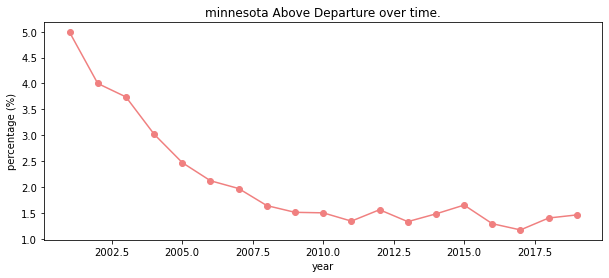

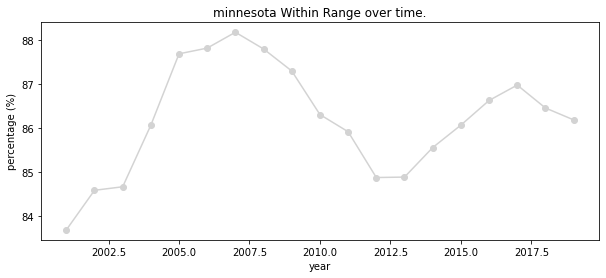

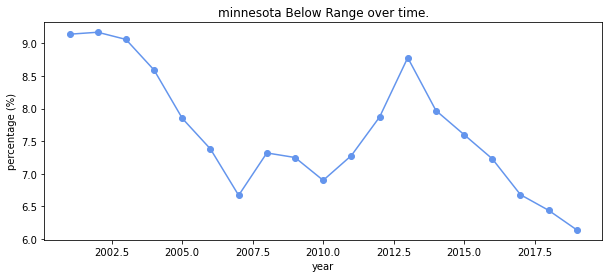

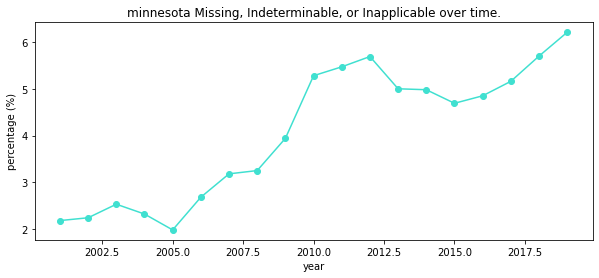

In [26]:
state_trends(states['minnesota'], compressed = False)

## generalizable_multi_level_summary

Grouping by any combination (or none) of factor variables.  There is only one assumption to calling this function:
* the last level passed into inp_list_of_groups.  Basically, calling with only \['departure'\] means we are not grouping by any factor variable.

In [14]:
def generalizable_multi_level_summary(stateobj, inp_list_of_groups = ['departure'], years = None, plot = 'stacked bar'):
    # we should have a subplots vs stacked parameter here maybe?  either do lots of individual graphs or stacked
    subset_dat = filter_years(stateobj, years)  #first, filter for the years we are looking for
    groups_to_filter_by = []  # this list keeps track of the column names in our stateobj.data we are grouping by
    # get the column names in our stateobj.data we are grouping by
    for group in inp_list_of_groups:
        groups_to_filter_by.append(stateobj.paths[group][0])
    #groups_to_filter_by.append(stateobj.paths['departure'][0])  # add departure as a group by on the end, as that is our 
                                                                # the variable we are looking at
    
    #grouping by 
    #divide by count(all_items_but_daparture) for departure percentages for each subgroup
    counts = subset_dat.groupby(groups_to_filter_by).count()
    perc = None #initializing, will get value in next lines
    if len(inp_list_of_groups) > 1: # if we are goruping by more than departure
        perc = round(100 * counts / subset_dat.groupby(groups_to_filter_by[:-1]).count(), 1)
    else:
        perc = round( (100 * counts/ subset_dat.shape[0]),2)  #if we are just grouping by departure, we divide by data frame length
    
    # renames the values that have levels
    l=0
    for group in inp_list_of_groups:
        if stateobj.paths[group][1] is not None:
            perc = perc.rename(stateobj.paths[group][1], level = l)
            counts = counts.rename(stateobj.paths[group][1], level = l)
        l += 1
    # pull the data we need from our dataframes    
    perc = perc.iloc[:,0]  # all columns are the same, so we pull the first one
    counts = counts.iloc[:,0]  # all columns are the same, so we pull the first one
    
    #create an output dataframe to return
    comb_df = pd.concat([counts,perc],axis=1)  # combine our two columns into a dataframe
    comb_df.columns = ['count', 'percent']  # rename columns 
    if plot == 'stacked bar':
        plot_df(stateobj, perc, 'stacked bar', inp_list_of_groups[:-1])  # call our plotting function
    elif plot == 'bar':
        plot_df(stateobj, perc, 'bar', inp_list_of_groups[:-1])
    elif plot == 'pie':
        plot_df(stateobj, counts, 'pie', inp_list_of_groups[:-1])

    return comb_df

count  \
race            sex    durdep                                             
American Indian Male   Within Range                               13187   
                       Above Departure                              376   
                       Below Range                                 1203   
                       Missing, Indeterminable, or Inapplicable     303   
                Female Within Range                                5322   
                       Above Departure                               64   
                       Below Range                                  221   
                       Missing, Indeterminable, or Inapplicable     179   
Asian           Male   Within Range                                5163   
                       Above Departure                              117   
                       Below Range                                  468   
                       Missing, Indeterminable, or Inapplicable     327   
                Female Within Range                                 886   
                       Above Departure                               11   
                       Below Range                                   33   
                       Missing, Indeterminable, or Inapplicable      67   
Black           Male   Within Range                               52918   
                       Above Departure                             1886   
                       Below Range                                 9079   
                       Missing, Indeterminable, or Inapplicable    2888   
                Female Within Range                                8601   
                       Above Departure                              165   
                       Below Range                                  497   
                       Missing, Indeterminable, or Inapplicable     940   
Hispanic        Male   Within Range                               12202   
                       Above Departure                              283   
                       Below Range                                 1126   
                       Missing, Indeterminable, or Inapplicable     536   
                Female Within Range                                1736   
                       Above Departure                               14   
                       Below Range                                   57   
                       Missing, Indeterminable, or Inapplicable     123   
 Other          Male   Within Range                                 153   
                       Above Departure                                3   
                       Below Range                                   10   
                       Missing, Indeterminable, or Inapplicable      15   
                Female Within Range                                  33   
                       Above Departure                                2   
                       Below Range                                    1   
                       Missing, Indeterminable, or Inapplicable       3   
White           Male   Within Range                              121966   
                       Above Departure                             2548   
                       Below Range                                 8321   
                       Missing, Indeterminable, or Inapplicable    5281   
                Female Within Range                               30796   
                       Above Departure                              386   
                       Below Range                                 1192   
                       Missing, Indeterminable, or Inapplicable    1523   

                                                                 percent  
race            sex    durdep                                             
American Indian Male   Within Range                                 87.5  
                       Above Departure                               2.5  
               

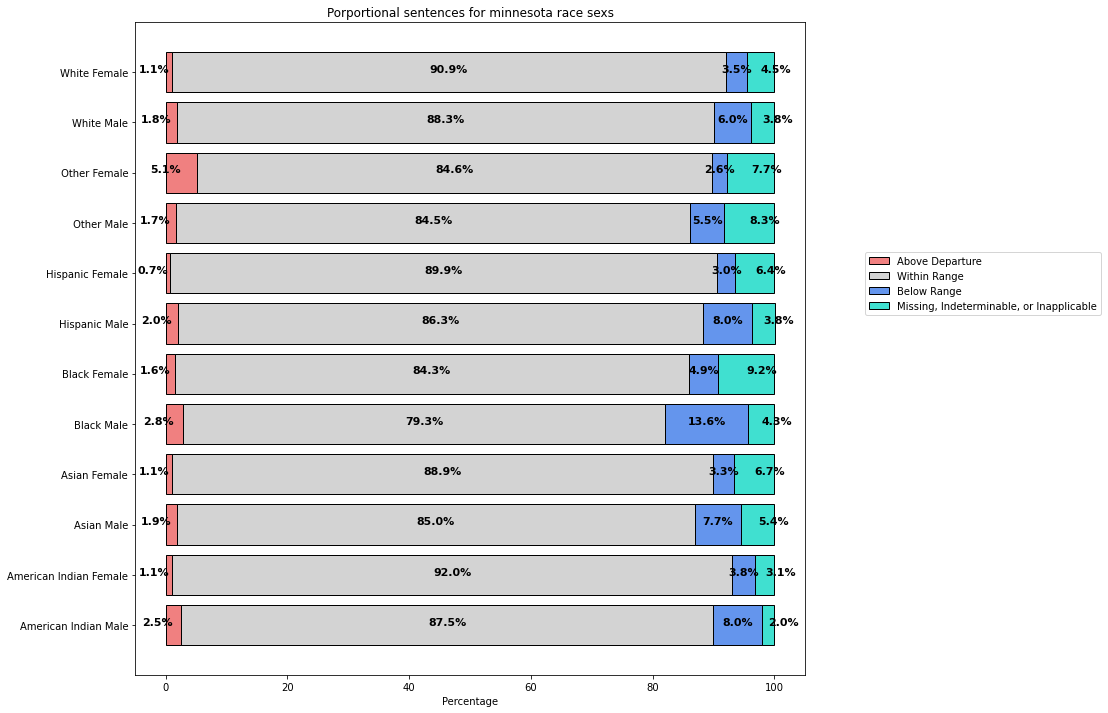

In [32]:
generalizable_multi_level_summary(states['minnesota'], inp_list_of_groups = ['race','sex','departure'], years = None, plot = 'stacked bar')

## subset_data_multi_level_summary

A slightly modified version of generalizable_multi_level_summary.  This is built to work with already filtered data.  It is used in individual_judge_analysis.

In [16]:
def subset_data_multi_level_summary(stateobj, subset_dat, inp_list_of_groups = ['departure'], plot = 'stacked bar'):
    groups_to_filter_by = []  # this list keeps track of the column names in our stateobj.data we are grouping by
    # get the column names in our stateobj.data we are grouping by
    for group in inp_list_of_groups:
        groups_to_filter_by.append(stateobj.paths[group][0])
    #groups_to_filter_by.append(stateobj.paths['departure'][0])  # add departure as a group by on the end, as that is our 
                                                                # the variable we are looking at
    
    #grouping by 
    #divide by count(all_items_but_daparture) for departure percentages for each subgroup
    counts = subset_dat.groupby(groups_to_filter_by).count()
    perc = None #initializing, will get value in next lines
    if len(inp_list_of_groups) > 1: # if we are goruping by more than departure
        perc = round(100 * counts / subset_dat.groupby(groups_to_filter_by[:-1]).count(), 1)
    else:
        perc = round( (100 * counts/ subset_dat.shape[0]),2)  #if we are just grouping by departure, we divide by data frame length
    
    # renames the values that have levels
    l=0
    for group in inp_list_of_groups:
        if stateobj.paths[group][1] is not None:
            perc = perc.rename(stateobj.paths[group][1], level = l)
            counts = counts.rename(stateobj.paths[group][1], level = l)
        l += 1
    # pull the data we need from our dataframes    
    perc = perc.iloc[:,0]  # all columns are the same, so we pull the first one
    counts = counts.iloc[:,0]  # all columns are the same, so we pull the first one
    
    #create an output dataframe to return
    comb_df = pd.concat([counts,perc],axis=1)  # combine our two columns into a dataframe
    comb_df.columns = ['count', 'percent']  # rename columns 
    if plot == 'stacked bar':
        plot_df(stateobj, perc, 'stacked bar', inp_list_of_groups[:-1])  # call our plotting function
    elif plot == 'bar':
        plot_df(stateobj, perc, 'bar', inp_list_of_groups[:-1])
    elif plot == 'pie':
        plot_df(stateobj, counts, 'pie', inp_list_of_groups[:-1])

    return comb_df

## Judge Analysis

In [17]:
def individual_judge_analysis(stateobj, judge_name, inp_list_of_groups = ['departure'], years = None, plot = True):
    judge_filtered_data = stateobj.data[stateobj.data[stateobj.paths['judge'][0]]== judge_name]
    # get the years where the judge was active
    overlapping_years = years
    if years is None:
        overlapping_years = np.sort(judge_filtered_data[stateobj.paths['year'][0]].unique())
    print(judge_name, 'was active in the years:', overlapping_years)
    
    groups_to_filter_by = []  # this list keeps track of the column names in our stateobj.data we are grouping by
    # get the column names in our stateobj.data we are grouping by
    for group in inp_list_of_groups:
        groups_to_filter_by.append(stateobj.paths[group][0])
    #groups_to_filter_by.append(stateobj.paths['departure'][0])  # add departure as a group by on the end, as that is our 
                                                                # the variable we are looking at
    
    #time to get the aggregate
    
    
    #grouping by 
    #divide by count(all_items_but_daparture) for departure percentages for each subgroup
    counts = judge_filtered_data.groupby(stateobj.paths['departure'][0]).count()
    perc = round( (100 * counts/ judge_filtered_data.shape[0]),2)  #if we are just grouping by departure, 
                                                                   #we divide by data frame length
    # renames the values that have levels
    perc = perc.rename(stateobj.paths['departure'][1], level = 0)
    counts = counts.rename(stateobj.paths['departure'][1], level = 0)

    # pull the data we need from our dataframes    
    perc = perc.iloc[:,0]  # all columns are the same, so we pull the first one
    counts = counts.iloc[:,0]  # all columns are the same, so we pull the first one
    
    #create an output dataframe to return
    agg_comb_df = pd.concat([counts,perc],axis=1)  # combine our two columns into a dataframe
    agg_comb_df.columns = ['count', 'percent']  # rename columns 
    
    state_avg_for_years = calc_state_avg_for_yearspan(stateobj, overlapping_years)
    judge_averages = []
    for departure_type in stateobj.order_of_outputs:
        judge_averages.append(perc.loc[departure_type,])
    
    if plot:
        plot_judge_vs_state(stateobj.order_of_outputs, judge_averages, 
                            state_avg_for_years, judge_name, stateobj.name)
    
    #now we plot the changes over time vs the state
    judge_data_y = np.zeros((len(overlapping_years), len(stateobj.order_of_outputs)))
    state_data_y = np.zeros((len(overlapping_years), len(stateobj.order_of_outputs)))
    for year in range(len(overlapping_years)):
        judge_year_data = judge_filtered_data[judge_filtered_data[stateobj.paths['year'][0]]== overlapping_years[year]]
        perc = round( (100 * judge_year_data.groupby(stateobj.paths['departure'][0]).count()/ judge_year_data.shape[0]),2)
        perc = perc.rename(stateobj.paths['departure'][1], level = 0)
        perc = perc.iloc[:,0]
        
        for departure_type in range(len(stateobj.order_of_outputs)):
            if stateobj.order_of_outputs[departure_type] in perc.index:
                judge_data_y[year, departure_type] = perc.loc[stateobj.order_of_outputs[departure_type]]
        
        state_data_y[year] = stateobj.yearly_average_percents[overlapping_years[year]]

    for departure_type in range(len(stateobj.order_of_outputs)):
        if judge_data_y[-1, departure_type] >= state_data_y[-1, departure_type]:
            print(judge_name, 'currently has a(n)', stateobj.order_of_outputs[departure_type], 'rate at or above state average in years queried')
        else:
            print(judge_name, 'currently has a(n)', stateobj.order_of_outputs[departure_type], 'rate below state average in years queried')
    
    if plot:
        plot_judge_vs_state_trends(stateobj, overlapping_years, judge_data_y, state_data_y, judge_name) 
        subset_data_multi_level_summary(stateobj, judge_filtered_data, inp_list_of_groups, plot = 'stacked bar')

Cunningham, James was active in the years: [2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019]
Cunningham, James currently has a(n) Above Departure rate below state average in years queried
Cunningham, James currently has a(n) Within Range rate at or above state average in years queried
Cunningham, James currently has a(n) Below Range rate below state average in years queried
Cunningham, James currently has a(n) Missing, Indeterminable, or Inapplicable rate below state average in years queried


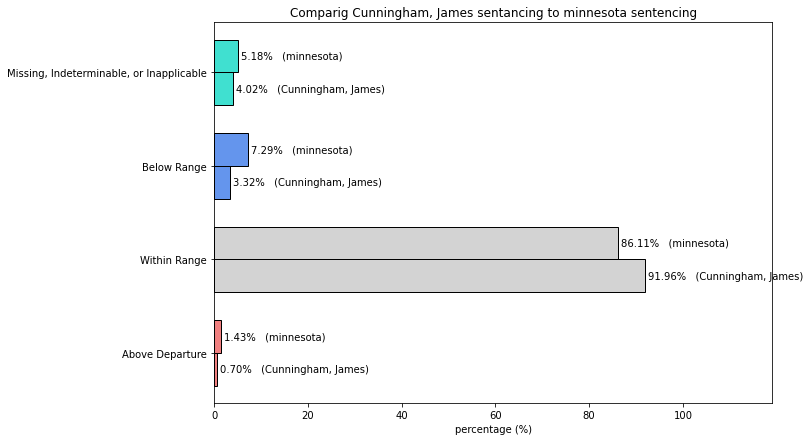

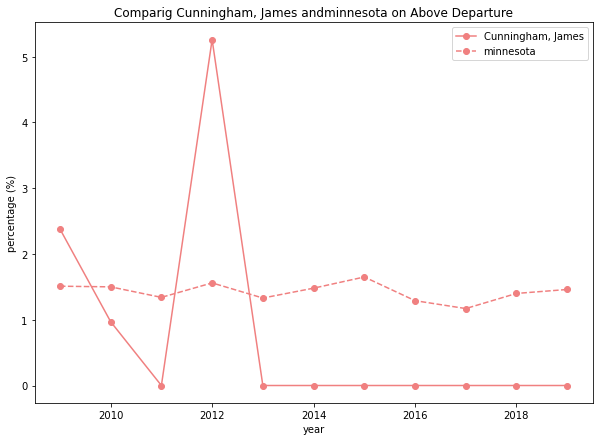

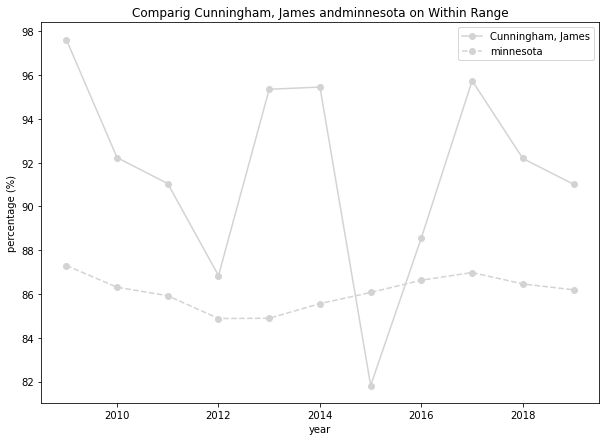

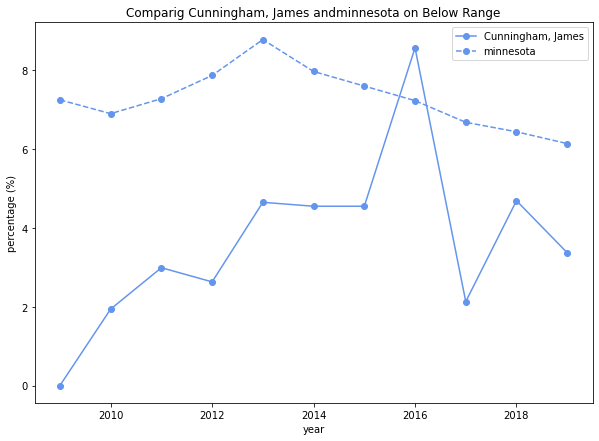

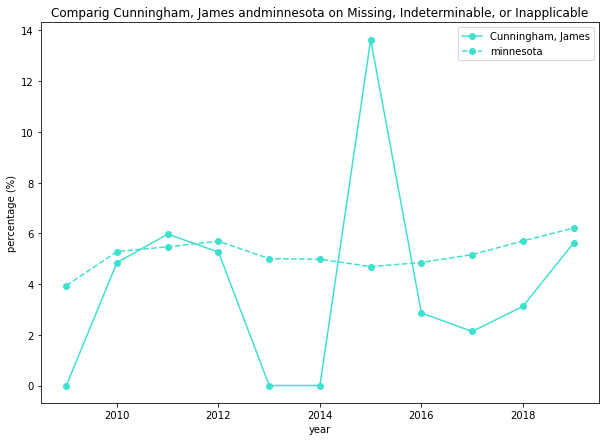

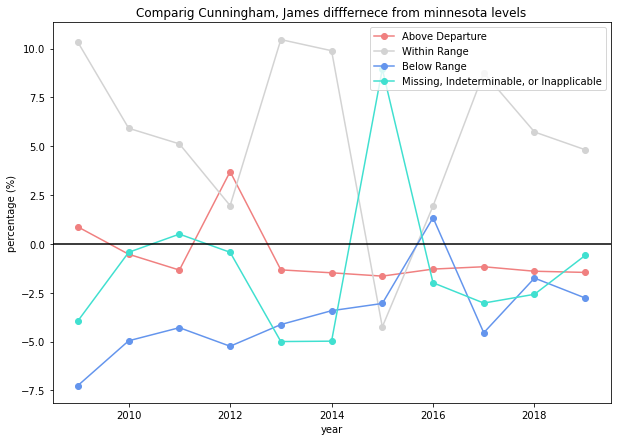

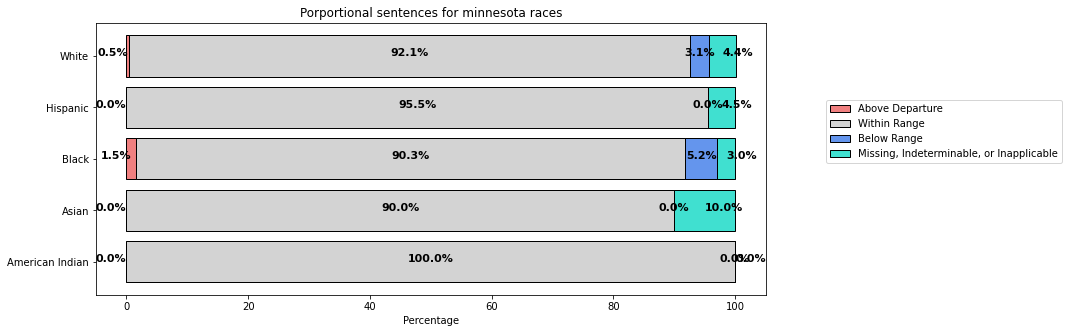

In [30]:
individual_judge_analysis(states['minnesota'], 'Cunningham, James',
                                    inp_list_of_groups = ['race','departure'], years = None, plot = True)